# AI Tools for Actuaries
## Chapter 8: Example Mortality Rate Forecasting with CNNs, RNNs and Transformers - PyTorch
### Author: Marco Maggi, Mario Wuthrich
### Version November 2025

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import warnings

warnings.filterwarnings("ignore")
np.random.seed(100)
torch.manual_seed(100)


def read_mortality_data(filepath):
    df = pd.read_csv(filepath, sep="\s+", skiprows=2)  # Skip header rows
    df.columns = ["Year", "Age", "Female", "Male", "Total"]

    # Clean data
    df = df.replace(".", np.nan)
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # Handle age notation (110+ becomes 110)
    df["Age"] = df["Age"].fillna(110)

    return df

In [2]:
# Load the mortality data
mort_data = read_mortality_data("../../Data/CHE.Mx_1x1.txt")

# Filter data
mort_data = mort_data[
    (mort_data["Age"] < 90) & (mort_data["Year"] > 1899) & (mort_data["Year"] < 2022)
]

# Melt data to long format
mort_data_melted = pd.melt(
    mort_data,
    id_vars=["Year", "Age"],
    value_vars=["Female", "Male"],
    var_name="Sex",
    value_name="mx",
)

# Calculate log-mortality rates (replace zero deaths with small number)
mort_data_melted["logmx"] = np.log(np.maximum(mort_data_melted["mx"], np.exp(-11)))

## Exploratory analysis & learn-test split

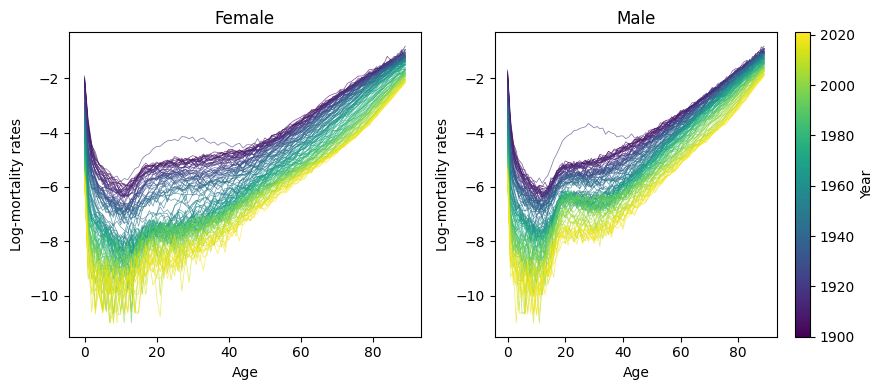

In [3]:
# Get all unique years for colormap
all_years = sorted(mort_data_melted["Year"].unique())
min_year = min(all_years)
max_year = max(all_years)

fig, axes = plt.subplots(1, 2, figsize=(9, 4))
for sex in ["Female", "Male"]:
    plot_i = 0 if sex == "Female" else 1
    mort_data_filtered = mort_data_melted[mort_data_melted["Sex"] == sex]

    for year in all_years:
        year_data = mort_data_filtered[mort_data_filtered["Year"] == year]
        # Normalize year to [0, 1] for colormap
        normalized_year = (year - min_year) / (max_year - min_year)
        color = plt.cm.viridis(normalized_year)

        axes[plot_i].plot(
            year_data["Age"],
            year_data["logmx"],
            alpha=0.7,
            linewidth=0.5,
            color=color,
        )

    axes[plot_i].set_xlabel("Age")
    axes[plot_i].set_ylabel("Log-mortality rates")
    axes[plot_i].set_title(f"{sex}")

    # Add colorbar for year
    sm = plt.cm.ScalarMappable(
        cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min_year, vmax=max_year)
    )
    sm.set_array([])
    if sex == "Male":
        cbar = plt.colorbar(sm, ax=axes[plot_i])
        cbar.set_label("Year")

plt.tight_layout()

In [4]:
obs_year = 1999
subset_data = mort_data_melted[mort_data_melted["Sex"] == "Male"].copy()
learn = subset_data[subset_data["Year"] <= obs_year].copy()
test = subset_data[subset_data["Year"] > obs_year].copy()
first_year = int(subset_data["Year"].min())
last_year = int(subset_data["Year"].max())

print(f"Data range: {first_year} to {last_year}")
print(f"Learning data: {first_year} to {obs_year}")
print(f"Test data: {obs_year + 1} to {last_year}")

Data range: 1900 to 2021
Learning data: 1900 to 1999
Test data: 2000 to 2021


## Lee-Carter model

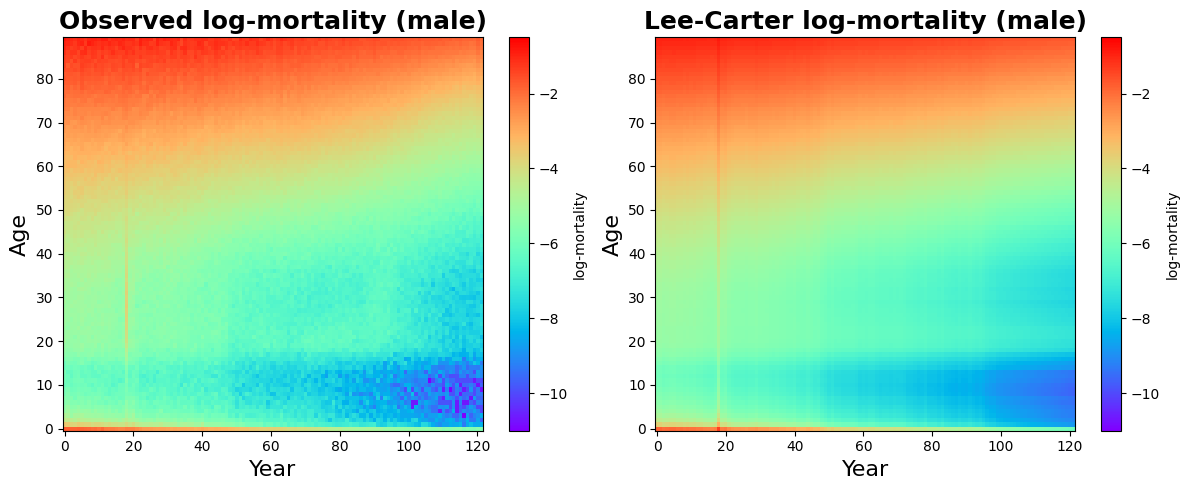

In [5]:
# Calculate ax (average log-mortality by age)
ax = learn.groupby("Age")["logmx"].mean().values
learn_lc = learn.copy()
learn_lc["ax"] = learn_lc["Age"].map(learn.groupby("Age")["logmx"].mean())
# center the log-mortality rates
learn_lc["mx_adj"] = learn_lc["logmx"] - learn_lc["ax"]

# Create log-mortality rates matrix
rates_pivot = learn_lc.pivot(index="Age", columns="Year", values="mx_adj")
rates_mat = rates_pivot.values

# Lee-Carter estimation using SVD (first principal component)
U, s, Vt = np.linalg.svd(rates_mat, full_matrices=False)
bx = U[:, 0] * s[0]
kt = Vt[0, :]

# Normalize components for identifiability
c1 = np.mean(kt)
c2 = np.sum(bx)
ax = ax + c1 * bx  # translate to center the kt's
bx = bx / c2  # scale to normalize the bx's
kt = (kt - c1) * c2  # center the kt's

# Forecast kt using random walk with drift (simple ARIMA(0,1,0) with drift)
kt_series = pd.Series(kt)
# Simple linear trend extrapolation for kt
time_points = np.arange(len(kt))
slope = np.polyfit(time_points, kt, 1)[0]
t_forecast = len(test["Year"].unique())
k_forecast = kt[-1] + slope * np.arange(1, t_forecast + 1)

# Construct fitted values and forecasts
years_learn = sorted(learn["Year"].unique())
years_test = sorted(test["Year"].unique())

# In-sample estimates
fitted_learn = ax[:, np.newaxis] + np.outer(bx, kt)
# Out-of-sample forecasts
fitted_test = ax[:, np.newaxis] + np.outer(bx, k_forecast)

# Add LC predictions to results
results = subset_data.copy()
results["LC"] = np.nan

# In-sample
for i, year in enumerate(years_learn):
    mask = results["Year"] == year
    results.loc[mask, "LC"] = fitted_learn[:, i]

# Out-of-sample
for i, year in enumerate(years_test):
    mask = results["Year"] == year
    results.loc[mask, "LC"] = fitted_test[:, i]


def plot_mortality(values, title, ax):
    z_min, z_max = -11, -0.5
    im = ax.imshow(
        values,
        aspect="auto",
        cmap="rainbow",
        vmin=z_min,
        vmax=z_max,
        origin="lower",
    )
    ax.set_title(title, fontsize=18, fontweight="bold")
    ax.set_xlabel("Year", fontsize=16)
    ax.set_ylabel("Age", fontsize=16)
    plt.colorbar(im, ax=ax, label="log-mortality")
    plt.tight_layout()
    return im


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Observed mortality
pivot_obs = results.pivot(index="Age", columns="Year", values="logmx")
im1 = plot_mortality(pivot_obs.values, "Observed log-mortality (male)", axes[0])

# Lee-Carter mortality
pivot_lc = results.pivot(index="Age", columns="Year", values="LC")
im2 = plot_mortality(pivot_lc.values, "Lee-Carter log-mortality (male)", axes[1])

## Definition of neural networks

In [6]:
class CNN1D_Model(nn.Module):
    def __init__(self, input_size, filters, kernel_size, stride, output_size, seed=100):
        super(CNN1D_Model, self).__init__()
        torch.manual_seed(seed)
        self.conv1d = nn.Conv1d(
            in_channels=input_size[1],
            out_channels=filters,
            kernel_size=kernel_size,
            stride=stride,
        )
        conv_output_size = ((input_size[0] - kernel_size) // stride) + 1
        self.flatten_size = filters * conv_output_size
        self.dense = nn.Linear(self.flatten_size, output_size)

    def forward(self, x):
        # x shape: (batch_size, seq_len, features)
        # Permute for Conv1D: (batch_size, features, seq_len)
        # Torch Notation: (N, C_in, L_in)
        x = x.permute(0, 2, 1)
        x = self.conv1d(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dense(x)
        return x


class CNN1D_Tanh_Model(nn.Module):
    def __init__(
        self,
        input_size,
        filters,
        kernel_size,
        stride,
        output_size,
        seed=100,
        qq=[20, 50],
    ):
        super(CNN1D_Tanh_Model, self).__init__()
        torch.manual_seed(seed)
        self.dense_1 = nn.Linear(input_size[1], qq[0])

        # Conv1D layer
        self.conv1d = nn.Conv1d(
            in_channels=qq[0],
            out_channels=filters,
            kernel_size=kernel_size,
            stride=stride,
        )
        conv_output_size = ((input_size[0] - kernel_size) // stride) + 1
        self.flatten_size = filters * conv_output_size

        # Dense layers after flattening
        self.dense_2 = nn.Linear(self.flatten_size, qq[1])
        self.dense_3 = nn.Linear(qq[1], output_size)

    def forward(self, x, gender=None):
        x = torch.tanh(self.dense_1(x))
        x = x.permute(0, 2, 1)
        x = self.conv1d(x)
        x = x.view(x.size(0), -1)
        x = torch.tanh(self.dense_2(x))
        x = self.dense_3(x)
        return x


class LSTM_Model(nn.Module):
    def __init__(self, input_size, q, units, output_size, seed=100):
        super(LSTM_Model, self).__init__()
        torch.manual_seed(seed)
        self.time_dense = nn.Linear(input_size[1], q)
        self.lstm = nn.LSTM(q, units, batch_first=True)
        self.output_dense = nn.Linear(units, output_size)

    def forward(self, x):
        x = self.time_dense(x)
        lstm_out, (h_n, c_n) = self.lstm(x)
        # Use last time step
        x = lstm_out[:, -1, :]
        x = self.output_dense(x)
        return x


class TRANSF_Model(nn.Module):
    def __init__(self, input_size, units, output_size, seed=100):
        super(TRANSF_Model, self).__init__()
        torch.manual_seed(seed)
        self.units = units
        self.seq_len = input_size[0]
        self.representation = nn.Linear(input_size[1], units)
        self.query_layer = nn.Linear(units, units)
        self.key_layer = nn.Linear(units, units)
        self.value_layer = nn.Linear(units, units)
        self.layer_norm = nn.LayerNorm(units)
        self.feed_forward = nn.Linear(units, units)
        self.output_dense = nn.Linear(units * input_size[0], output_size)

    def forward(self, x):
        representation = self.representation(x)
        query = self.query_layer(representation)
        key = self.key_layer(representation)
        value = self.value_layer(representation)
        # Scaled dot-product attention
        scores = torch.matmul(query, key.transpose(-2, -1)) / torch.sqrt(
            torch.tensor(self.units, dtype=torch.float32)
        )
        attention_weights = torch.softmax(scores, dim=-1)
        attention_output = torch.matmul(attention_weights, value)
        skip_1 = attention_output + representation
        normalized = self.layer_norm(skip_1)
        skip_2 = self.feed_forward(normalized)
        features = skip_2 + skip_1
        features = features.view(features.size(0), -1)  # Flatten
        output = self.output_dense(features)
        return output

## Data preprocessing for neural networks

We use MinMax scaling for transforming the log-mortality.

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [8]:
lookback = 10
n_age = len(subset_data["Age"].unique())
n_sample = len(range(first_year + lookback, obs_year + 1))
print(f"Number of samples: {n_sample}")
print(f"Number of ages: {n_age}")

# MinMax scaling
subset_data_scaled = subset_data.copy()
subset_data_scaled["logmx_scaled"] = scaler.fit_transform(subset_data[["logmx"]])

# Prepare training data
x_learn = np.zeros((n_sample, lookback, n_age))
y_learn = np.zeros((n_sample, n_age))

for i, year in enumerate(range(first_year + lookback, obs_year + 1)):
    # Get lookback years of data
    lookback_data = subset_data_scaled[
        (subset_data_scaled["Year"] >= year - lookback)
        & (subset_data_scaled["Year"] < year)
    ]
    lookback_pivot = lookback_data.pivot(
        index="Year", columns="Age", values="logmx_scaled"
    )

    # Get target year data
    target_data = subset_data_scaled[subset_data_scaled["Year"] == year]

    # the covariates are the log-mortality rates from the lookback years
    # for each age.
    x_learn[i] = lookback_pivot.values
    # the response variable is the log-mortality rate for each age for the year after
    # the last of the lookback years.
    y_learn[i] = target_data["logmx_scaled"].values

print(f"Final training data shape: x_learn={x_learn.shape}, y_learn={y_learn.shape}")

# Shuffle for training
np.random.seed(100)
indices = np.random.permutation(len(x_learn))
x_learn_shuffled = x_learn[indices]
y_learn_shuffled = y_learn[indices]

# Convert to tensors
x_train_tensor = torch.FloatTensor(x_learn_shuffled)
y_train_tensor = torch.FloatTensor(y_learn_shuffled)
x_learn_tensor = torch.FloatTensor(
    x_learn
)  # Keep original order for in-sample prediction

Number of samples: 90
Number of ages: 90
Final training data shape: x_learn=(90, 10, 90), y_learn=(90, 90)


In [9]:
from copy import deepcopy


def train_model(
    model, x_learn, y_learn, epochs=1000, batch_size=4, lr=0.001, patience=5
):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, factor=0.9, patience=patience, verbose=True
    )

    # Split data for validation
    val_split = int(0.9 * len(x_learn))
    x_val = x_learn[val_split:]
    y_val = y_learn[val_split:]
    x_train = x_learn[:val_split]
    y_train = y_learn[:val_split]

    train_losses = []
    val_losses = []
    best_val_loss = float("inf")

    for epoch in range(epochs):
        model.train()

        # Training
        for i in range(0, len(x_train), batch_size):
            batch_x = x_train[i : i + batch_size]
            batch_y = y_train[i : i + batch_size]
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(x_val)
            val_loss = criterion(val_outputs, y_val).item()
            train_outputs = model(x_train)
            train_loss = criterion(train_outputs, y_train).item()

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = deepcopy(model.state_dict())

        if epoch % 100 == 0:
            print(
                f"Epoch {epoch}: Train Loss = {train_loss:.6f}, Val Loss = {val_loss:.6f}"
            )

    # Load best model
    model.load_state_dict(best_model_state)
    return model, train_losses, val_losses

In [10]:
from sklearn.metrics import root_mean_squared_error


def predict_and_forecast(
    model, model_name, x_learn_tensor, results, subset_data_scaled, obs_year, scaler
):
    model.eval()
    lookback = x_learn_tensor.shape[1]
    n_age = x_learn_tensor.shape[2]
    last_year = subset_data_scaled["Year"].max()
    first_year = subset_data_scaled["Year"].min()
    # In-sample prediction
    with torch.no_grad():
        logmx_hat_learn = model(x_learn_tensor).detach().numpy()

    # Add predictions to results
    results[model_name] = np.nan
    for i, year in enumerate(range(first_year + lookback, obs_year + 1)):
        mask = results["Year"] == year
        results.loc[mask, model_name] = scaler.inverse_transform(
            logmx_hat_learn[[i]]
        ).flatten()

    # Out-of-sample forecasting
    starting_matrix = np.zeros((1, lookback, n_age))
    last_years_data = subset_data_scaled[
        (subset_data_scaled["Year"] > obs_year - lookback)
        & (subset_data_scaled["Year"] <= obs_year)
    ]
    last_years_pivot = last_years_data.pivot(
        index="Year", columns="Age", values="logmx_scaled"
    )
    starting_matrix[0] = last_years_pivot.values

    for year in range(obs_year + 1, last_year + 1):
        with torch.no_grad():
            starting_tensor = torch.FloatTensor(starting_matrix)
            y_test = model(starting_tensor).detach().numpy()[0]

        mask = results["Year"] == year
        results.loc[mask, model_name] = scaler.inverse_transform(
            y_test[:, None]
        ).flatten()

        # Update starting matrix for next iteration.
        starting_matrix[0, :-1] = starting_matrix[0, 1:]
        # The latest year of the 10 years window is the predicted year.
        starting_matrix[0, -1] = y_test


def plot_model_comparison(results, model_name, z_min, z_max):
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    pivot_obs = results.pivot(index="Age", columns="Year", values="logmx")
    im1 = plot_mortality(pivot_obs.values, "Observed log-mortality (male)", axes[0])
    pivot_model = results.pivot(index="Age", columns="Year", values=model_name)
    im2 = plot_mortality(pivot_model.values, f"{model_name} log-mortality", axes[1])
    plt.show()


def evaluate_model(results, model_name, first_year, lookback, obs_year):
    # In-sample results
    in_sample_mask = (results["Year"] >= first_year + lookback) & (
        results["Year"] <= obs_year
    )
    in_sample_data = results[in_sample_mask]
    in_rmse = root_mean_squared_error(
        in_sample_data["logmx"], in_sample_data[model_name]
    )
    # Out-of-sample results
    out_sample_mask = results["Year"] > obs_year
    out_sample_data = results[out_sample_mask]
    out_rmse = root_mean_squared_error(
        out_sample_data["logmx"], out_sample_data[model_name]
    )

    print(
        f"{model_name} - In-sample RMSE: {in_rmse:.4f}, Out-of-sample RMSE: {out_rmse:.4f}"
    )
    return in_rmse, out_rmse

## Train models

In [11]:
# Dictionary to store all models and their configurations
model_configs = {
    "CNN": {
        "model": CNN1D_Model(
            input_size=(lookback, n_age),
            filters=3,
            kernel_size=3,
            stride=1,
            output_size=n_age,
        ),
        "name": "CNN",
    },
    "CNN_TANH": {
        "model": CNN1D_Tanh_Model(
            input_size=(lookback, n_age),
            filters=3,
            kernel_size=3,
            stride=1,
            output_size=n_age,
            qq=[20, 20],
        ),
        "name": "CNN_TANH",
    },
    "LSTM": {
        "model": LSTM_Model(
            input_size=(lookback, n_age), q=20, units=20, output_size=n_age
        ),
        "name": "LSTM",
    },
    "TRANS": {
        "model": TRANSF_Model(input_size=(lookback, n_age), units=3, output_size=n_age),
        "name": "TRANS",
    },
}

# Train all models and make predictions
trained_models = {}
rmse_results = {}
# First add Lee-Carter results
in_rmse, out_rmse = evaluate_model(results, "LC", first_year, lookback, obs_year)
rmse_results["LC"] = {"in_sample": in_rmse, "out_sample": out_rmse}

for model_key, config in model_configs.items():
    print(f"\nTraining {config['name']} model...")

    # Train model
    model, train_losses, val_losses = train_model(
        config["model"], x_train_tensor, y_train_tensor, epochs=1000
    )
    trained_models[model_key] = model

    # Make predictions and forecasts
    predict_and_forecast(
        model,
        config["name"],
        x_learn_tensor,
        results,
        subset_data_scaled,
        obs_year,
        scaler,
    )

    # Evaluate model
    in_rmse, out_rmse = evaluate_model(
        results, config["name"], first_year, lookback, obs_year
    )
    rmse_results[config["name"]] = {"in_sample": in_rmse, "out_sample": out_rmse}

    # Print number of parameters
    n_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
    print(f"{config['name']} - Number of parameters: {n_params}")

LC - In-sample RMSE: 0.1555, Out-of-sample RMSE: 0.3425

Training CNN model...
Epoch 0: Train Loss = 0.250285, Val Loss = 0.253092
Epoch 100: Train Loss = 0.000281, Val Loss = 0.001058
Epoch 200: Train Loss = 0.000247, Val Loss = 0.000951
Epoch 300: Train Loss = 0.000241, Val Loss = 0.000923
Epoch 400: Train Loss = 0.000241, Val Loss = 0.000924
Epoch 500: Train Loss = 0.000241, Val Loss = 0.000925
Epoch 600: Train Loss = 0.000241, Val Loss = 0.000925
Epoch 700: Train Loss = 0.000241, Val Loss = 0.000925
Epoch 800: Train Loss = 0.000241, Val Loss = 0.000925
Epoch 900: Train Loss = 0.000241, Val Loss = 0.000925
CNN - In-sample RMSE: 0.1808, Out-of-sample RMSE: 0.4281
CNN - Number of parameters: 3063

Training CNN_TANH model...
Epoch 0: Train Loss = 0.195845, Val Loss = 0.198773
Epoch 100: Train Loss = 0.000295, Val Loss = 0.000977
Epoch 200: Train Loss = 0.000278, Val Loss = 0.000927
Epoch 300: Train Loss = 0.000250, Val Loss = 0.000844
Epoch 400: Train Loss = 0.000288, Val Loss = 0.0008

RMSE summary:


,LC,CNN,CNN_TANH,LSTM,TRANS
in_sample,0.1555,0.1808,0.1570,0.1595,0.1819
out_sample,0.3425,0.4281,0.3533,0.3428,0.3831


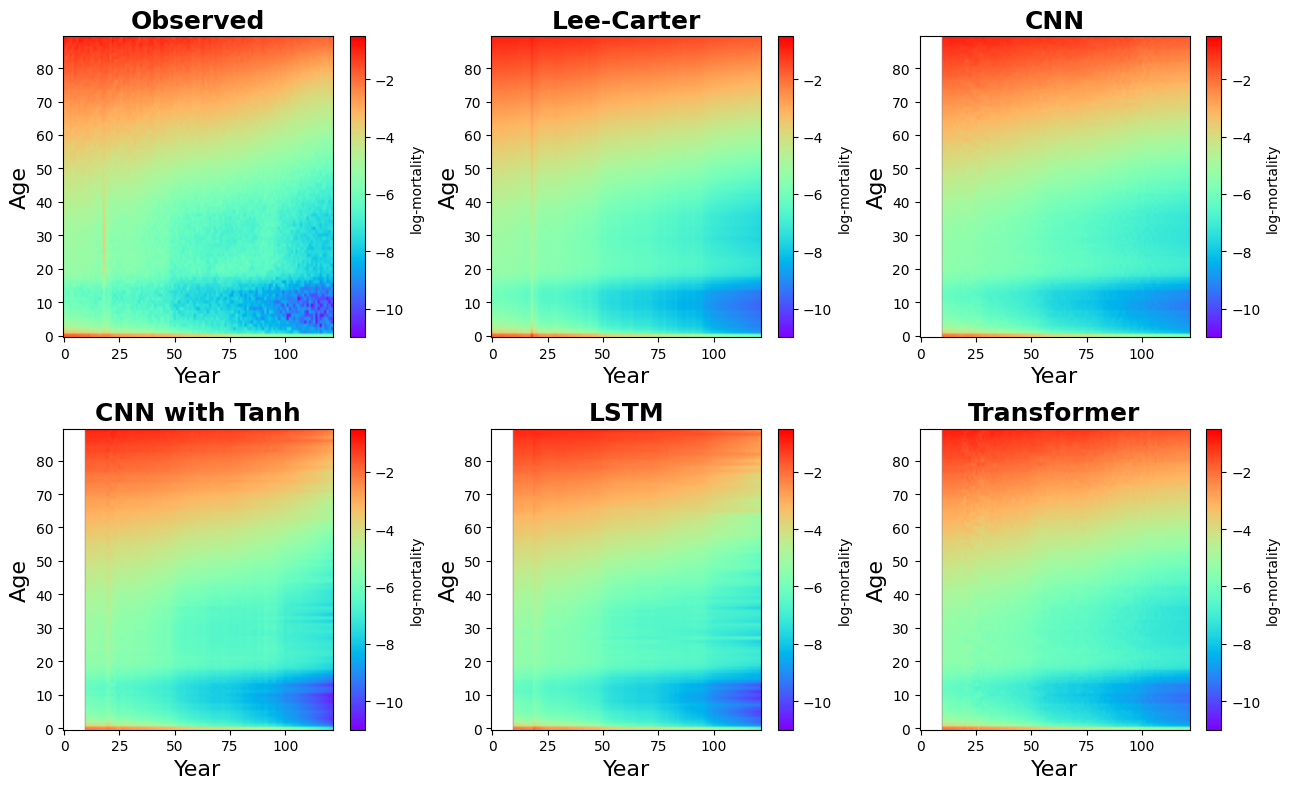

In [12]:
print("RMSE summary:")
display(pd.DataFrame(rmse_results).apply(lambda x: round(x, 4)))

# Plot all models comparison in a grid
fig, axes = plt.subplots(2, 3, figsize=(13, 8))
axes = axes.flatten()

all_models = ["logmx", "LC", "CNN", "CNN_TANH", "LSTM", "TRANS"]
all_titles = ["Observed", "Lee-Carter", "CNN", "CNN with Tanh", "LSTM", "Transformer"]

for i, (model, title) in enumerate(zip(all_models, all_titles)):
    if i < len(axes):
        pivot_model = results.pivot(index="Age", columns="Year", values=model)
        im = plot_mortality(pivot_model.values, f"{title}", axes[i])